# Классификация музыки

## Описание задачи

Музыкальный сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача: правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Существует подготовленный датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Основная задача - разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

## План работы

* импорт инструментария,
* загрузка данных,
* ознакомление с данными,
* предварительная обработка:
    * работа с пропусками,
    * избавление от аномалий,
    * преобразование категориальных признаков.
* полноценный разведочный анализ,
* разработка новых синтетических признаков,
* проверка на мультиколлинеарность,
* отбор финального набора обучающих признаков,
* выбор и обучение моделей,
* итоговая оценка качества предсказания лучшей модели,
* анализ важности ее признаков,
* отчет по исследованию

# Импорт инструментария

In [1]:
import time #импорт инструмента обработки дат

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 

import matplotlib.pyplot as plt #импорт инструмента построения графиков


from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn. preprocessing import OneHotEncoder #импорт инструмента кодирования
from sklearn.preprocessing import StandardScaler #импорт инструмента масштабирования
from sklearn.feature_extraction.text import TfidfVectorizer #импорт инструмента для расчёта TF-IDF
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import lightgbm as lgb
from catboost import CatBoostClassifier

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')


import nltk #импорт библиотеки для работы с Natural Language
from nltk.corpus import stopwords as nltk_stopwords #импорт инструмента для определения стоп-слов

import spacy #импорт инструмента лемматизации

from tqdm import tqdm #импорт инструмента процесса выполнения циклов

import re #импорт модуля для работы с регулярными выражениями(для очистки)


In [2]:
#установка максимального числа символов для отображения в ячейке 
pd.set_option('display.max_colwidth', 200)

# Загрузка данных

In [3]:
#загрузка тренировочного датасета
df_train=pd.read_csv('/kaggle/input/music-genre/kaggle_music_genre_train.csv')
#загрузка тестового датасета
df_test=pd.read_csv('/kaggle/input/music-genre/kaggle_music_genre_test.csv')
#загрузка датасета-примера результата
df_sample=pd.read_csv('/kaggle/input/music-genre/sample_submit.csv')

# Ознакомление с данными

Из документации:

**Данные**
* train.csv - информация (~20000) музыкальных треках, которые будут использоваться в качестве обучающих данных.
* test.csv - информация (~5000) музыкальных треках, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'music_genre' для каждого трека из этого датасета.
* sample_submit.csv - файл предсказаний в правильном формате.
* instance_id - идентификатор трека в тестовом наборе.
* music_genre - Целевой признак. Для каждого трека предскажите категориальное значение соответствующее музыкальному жанру трека.

**Описание полей данных**
* instance_id - уникальный идентификатор трека
* track_name - название трека
* acousticness - акустичность
* danceability - танцевальность
* duration_ms -продолжительность в миллисекундах
* energy - энергичность
* instrumentalness - инструментальность
* key - базовый ключ (нота) произведения
* liveness - привлекательность
* loudness - громкость
* mode - указывает на модальность (мажорную или минорную) трека
* speechiness - выразительность
* tempo - темп
* obtained_date - дата загрузки в сервис
* valence - привлекательность произведения для пользователей сервиса
* music_genre - музыкальный жанр

## Тренировочный датасет

In [4]:
#вывод информации методом info()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [5]:
#подсчёт числа пропусков в процентах
pd.DataFrame(round(df_train.isna().mean()*100,),columns=['% пропусков']).style.background_gradient('coolwarm')

,% пропусков
instance_id,0.000000
track_name,0.000000
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,4.000000
liveness,0.000000
loudness,0.000000


In [6]:
#вывод первых строк датасета
df_train.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative


In [7]:
#вывод информации методом describe()
df_train.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,20394.000000,20394.000000,20394.000000,2.039400e+04,20394.000000,20394.000000,20394.000000,20394.000000,20394.000000,19952.000000,20394.000000
mean,55973.846916,0.274783,0.561983,2.203754e+05,0.625276,0.159989,0.198540,-8.552998,0.091352,120.942522,0.464588
std,20695.792545,0.321643,0.171898,1.267283e+05,0.251238,0.306503,0.166742,5.499917,0.097735,30.427590,0.243387
min,20011.000000,0.000000,0.060000,-1.000000e+00,0.001010,0.000000,0.013600,-44.406000,0.022300,34.765000,0.000000
25%,38157.250000,0.015200,0.451000,1.775170e+05,0.470000,0.000000,0.097300,-10.255750,0.035600,95.921750,0.272000
50%,56030.000000,0.120000,0.570000,2.195330e+05,0.666000,0.000144,0.130000,-7.052000,0.049050,120.012500,0.457000
75%,73912.750000,0.470000,0.683000,2.660000e+05,0.830000,0.084475,0.253000,-5.054000,0.095575,141.966250,0.653000
max,91758.000000,0.996000,0.978000,4.497994e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.041000,0.992000


Посмотрим по столбцам: 
* acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence - содержат свою отградуированную музыкальну характеристику от 0 до 1; 
* duration_ms - время в миллисекундах, подозрительные значения - минимальное (отрицательное) и максимальное (надо проверить длину трека в минутах);
* loudness, tempo - явных подозрительных значений нет, loudness видимо отградуирован в диапазоне начиная с отрицательных чисел, а tempo содержит абсолютное значение в количестве ударов в минуту.

In [8]:
#вывод максимального значения в столбце duration_ms в минутах:
df_train['duration_ms'].max()/(60*10**3)

74.96656666666667

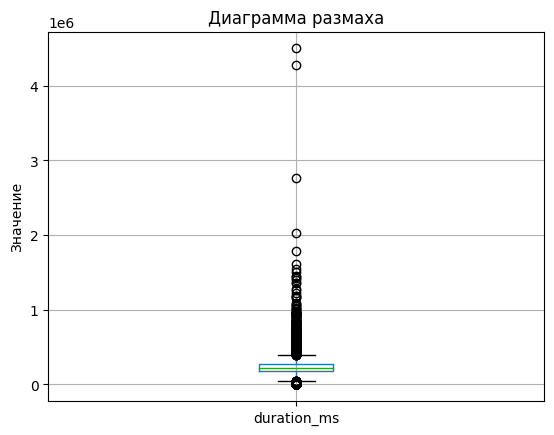

In [9]:
#построение диаграммы размаха по столбцу duration_ms
df_train.boxplot('duration_ms')
plt.title('Диаграмма размаха')
plt.ylabel('Значение')
plt.show()

In [10]:
#вывод строки с максимальным значением по столбцу 
df_train[['track_name','duration_ms','music_genre']].sort_values(by='duration_ms',ascending=False).head()

,track_name,duration_ms,music_genre
20117,Late Night Tales: Bonobo,4497994.0,Electronic
4502,Mixtape 13,4276000.0,Electronic
8222,45:33:00,2764934.0,Electronic
10699,"Mountain Jam (Theme From “First There Is A Mountain”) - Live At The Fillmore East, 1971",2019293.0,Blues
6343,Symphony No. 6 in A Minor: 4. Finale (Allegro moderato),1778440.0,Classical


Отсюда видно следующее: Mixtape 13, 45:33:00 и далее - не содержат подозрительной длины: это реальные треки с такой длиной. А вот самый длиинный трек это альбом - Late Night Tales: Bonobo, то есть это не совсем корректно выложенный альбом. При этом, можно утверждать, что 3 самых длинных и сопоставимых по длине позиции относятся к жанру music_genre, и действительно соответствуют ему. Следовательно, выбросом строку с Late Night Tales: Bonobo можно не считать.

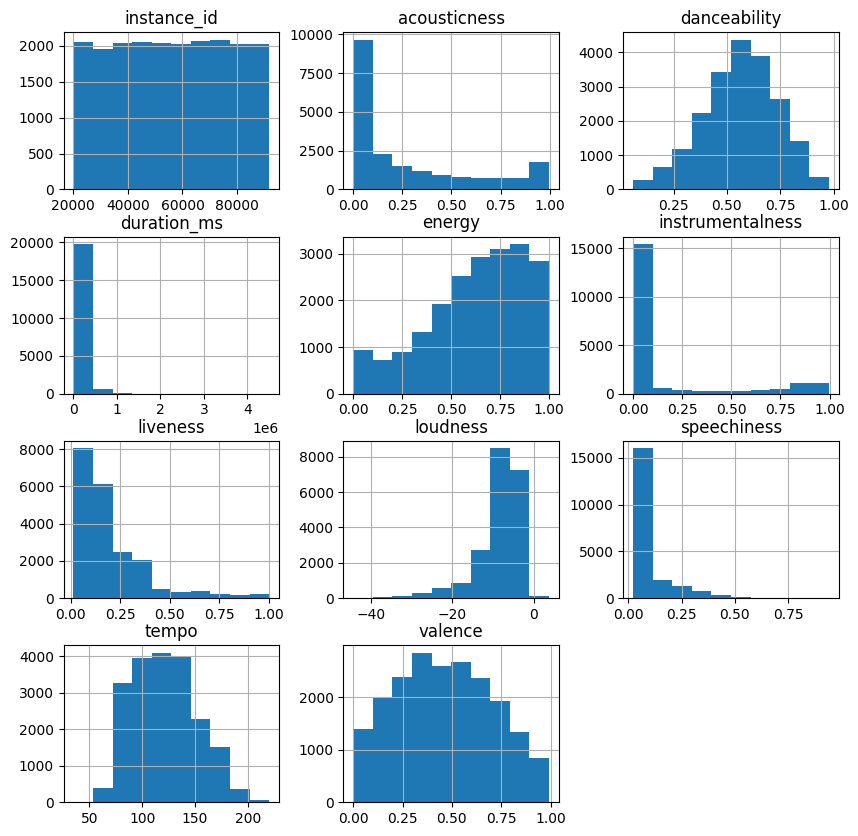

In [11]:
#вывод гистограмм по числовым столбцам
df_train.hist(figsize=(10,10));

### Выводы по тренировочному датасету

По результатам ознакомления с датасетом можно сделать следующие выводы.

**Общее:**
* датасет содержит 16 столбцов, как и заявлено
* основные представленные типы данных - object и float64, что коррелирует со значениями в столбцах. Стоит отметить: столбец obtained_date (дата загрузки в сервис) - дата, но тип - object.

**Пропуски:**
* в датасете есть пропуски в столбцах key(4%), mode(2%),tempo(2%)

**Выбросы:**
* в датасете есть выбросы по строке duration_ms: отрицательные значения длины трека

**Распределение значений**
* столбцы danceability, tempo, valence имеют близкое к нормальному распределение значений;
* столбец energy имеет распределение близкое к нормальному, пик которого смещён вправо;
* судя по столбцу acousticness, большинство песен имеют небольшую акустичность (большинтсво в пределах (0,0.1), с небольшим выделяющимся значением в районе 1 (видимо это полностью акустические треки);
* instrumentalness - ситуация аналогичная acousticness: большинство треков не слишком инструментальны, но есть небольшое, но выделяющееся количество треков с значительным использованием инструментов;
* duration - абсолютное преимующество имеют короткие песни (до 0.3* 10^6 милисекунд, или примерно 5 минут), но есть и исключения
* loudness - распределение, стремщееся к нормальному, но с сильным пиком в районе медианы, которая смещена вправо;
* speechiness - выразительность, распределение значений показывает пик на небольших значениях (до 0.1)загрузка и ознакомление с данными,
предварительная обработка,
полноценный разведочный анализ,
разработка новых синтетических признаков,
проверка на мультиколлинеарность,
отбор финального набора обучающих признаков,
выбор и обучение моделей,
итоговая оценка качества предсказания лучшей модели,
анализ важности ее признаков.загрузка и ознакомление с данными,
предварительная обработка,
полноценный разведочный анализ,
разработка новых синтетических признаков,
проверка на мультиколлинеарность,
отбор финального набора обучающих признаков,
выбор и обучение моделей,
итоговая оценка качества предсказания лучшей модели,
анализ важности ее признаков.

## Тестовый датасет

In [12]:
#вывод информации методом info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


In [13]:
#подсчёт числа пропусков в процентах
pd.DataFrame(round(df_test.isna().mean()*100,),columns=['% пропусков']).style.background_gradient('coolwarm')

,% пропусков
instance_id,0.000000
track_name,0.000000
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,3.000000
liveness,0.000000
loudness,0.000000


In [14]:
#вывод первых строк датасета
df_test.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,48564,Low Class Conspiracy,0.301000,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0.895
1,72394,The Hunter,0.538000,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0.318
2,88081,Hate Me Now,0.005830,0.678,284000.0,0.770,0.00000,A,0.1090,-4.399,Minor,0.2220,90.000,4-Apr,0.412
3,78331,Somebody Ain't You,0.020300,0.592,177354.0,0.749,0.00000,B,0.1220,-4.604,Major,0.0483,160.046,4-Apr,0.614
4,72636,Sour Mango,0.000335,0.421,-1.0,0.447,0.01480,D,0.0374,-8.833,Major,0.2020,73.830,4-Apr,0.121


In [15]:
#вывод информации методом describe()
df_test.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,5099.000000,5099.000000,5099.000000,5.099000e+03,5099.000000,5099.000000,5099.000000,5099.000000,5099.000000,4978.000000,5099.000000
mean,55643.871347,0.276324,0.561888,2.173974e+05,0.622030,0.165198,0.197924,-8.630186,0.092718,121.246463,0.465593
std,20762.384803,0.322657,0.170502,1.156374e+05,0.251829,0.311940,0.166241,5.619766,0.100130,29.875950,0.244217
min,20012.000000,0.000002,0.059600,-1.000000e+00,0.001540,0.000000,0.020400,-46.122000,0.022600,37.114000,0.020500
25%,37571.000000,0.016600,0.451000,1.737335e+05,0.465000,0.000000,0.096950,-10.231000,0.035700,96.070250,0.272000
50%,55246.000000,0.120000,0.568000,2.175000e+05,0.660000,0.000157,0.129000,-7.135000,0.048700,120.053500,0.458000
75%,73702.000000,0.460000,0.681000,2.642470e+05,0.826000,0.092750,0.248000,-5.127000,0.096550,141.934250,0.650000
max,91709.000000,0.996000,0.977000,1.360027e+06,0.999000,0.994000,0.990000,1.949000,0.918000,216.029000,0.982000


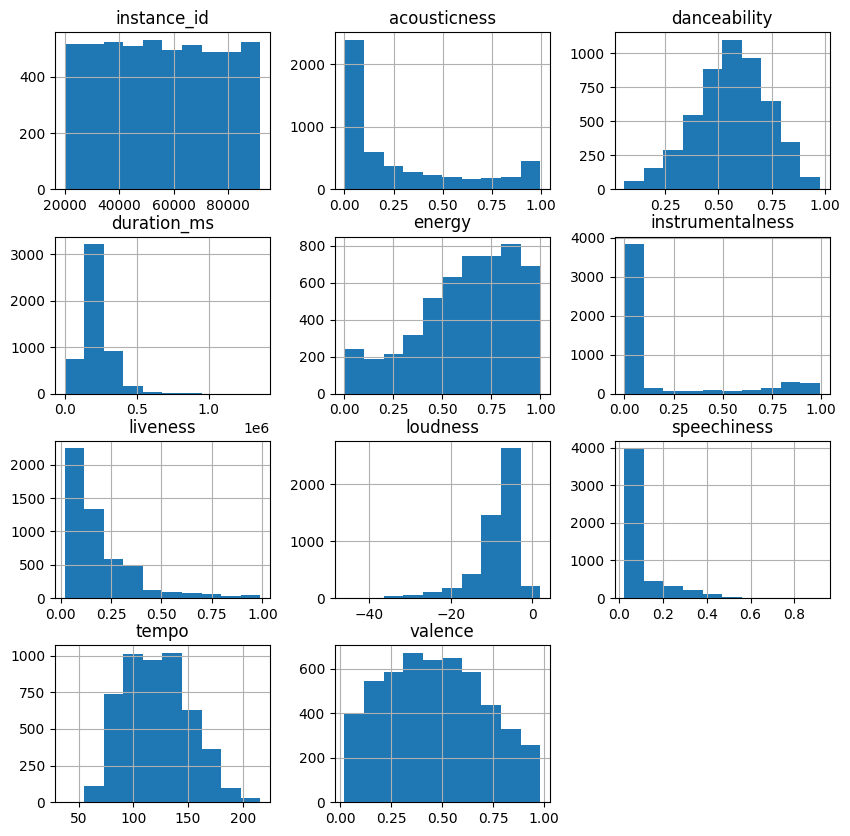

In [16]:
#вывод гистограмм по числовым столбцам
df_test.hist(figsize=(10,10));

### Выводы по тестовому датасету

По результатам ознакомления с датасетом можно сделать следующие выводы.

**Общее:**
* датасет содержит 15 столбцов, как и заявлено: на 1 (целевой music_genre);
* основные представленные типы данных - object и float64, что коррелирует со значениями в столбцах. Стоит отметить, что аналогично df_train столбец obtained_date (дата загрузки в сервис) - дата, но тип - object;
* в принципе датасет имеет такую же структуру, как и тренировочный.

**Пропуски:**
* в датасете есть пропуски в столбцах key(3%), mode(3%),tempo(2%).

**Выбросы:**
* в датасете есть выбросы по строке duration_ms: отрицательные значения длины трека.

**Распределение значений**
* в целом аналогично распределениям df_train.



## Датасет с примером предсказаний

В данном случае есть смысл рассмотреть структуру данных и пример строк, распределения/пропуски рассматривать не будем.

In [17]:
#вывод информации методом info()
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instance_id  5099 non-null   int64 
 1   music_genre  5099 non-null   object
dtypes: int64(1), object(1)
memory usage: 79.8+ KB


In [18]:
#вывод первых строк датасета
df_sample.head()

,instance_id,music_genre
0,48564,Hip-Hop
1,72394,Alternative
2,88081,Rap
3,78331,Anime
4,72636,Anime


### Выводы по датасету-примеру предсказаний

По результатам ознакомления с датасетом можно сделать следующие выводы.

**Общее:**
* датасет содержит 2 столбца: instance_id и music_genre;
* instance_id - тип данных int64, music_genre - object.

# Предобработка данных

Предобработку данных будем выполнять для тренировочного датасета df_train. Необходимо:
* преобразовывать формат данных столбца obtained_date пока не будем: по смыслу как будто дата выгрузки ни на что не влияет и этот столбец надо будет удалить из признаков;
* обработать пропуски столбцов key, mode, tempo: категориальные key и mode заполним значением-заглушкой, tempo - медианой по сгруппированным по музыкальному жанру данным;
* изучить и скорее всего удалить строки с отрицательными значениями по duration_ms (длительность не может быть отрицательной);
* обработать данные категориальных признаков:
    * mode, key - преобразование через OHE;
    * track_name: векторизовать при помощи tf-idf и преобразовать sparce matrix в более короткий вектор методом truncatedSVD.

## Обработка пропусков

### Столбец key
Заполняем заглушкой


In [19]:
#выводим число пропусков по столбцу
len(df_train[df_train['key'].isna()])

735

In [20]:
#заполняем пропуски заглушкой
df_train['key']=df_train['key'].fillna('X')

In [21]:
#проверка числа пропусков
len(df_train[df_train['key'].isna()])

0

### Столбец tempo
Заполняем медианным значением по жанру


In [22]:
#выводим число пропусков по столбцу
len(df_train[df_train['tempo'].isna()])

442

In [23]:
#выведем сгруппированные медианные значения
df_train.groupby('music_genre')['tempo'].median()

music_genre
Alternative    120.0480
Anime          128.0020
Blues          119.1180
Classical       95.5235
Country        121.9700
Electronic     126.0000
Hip-Hop        120.1000
Jazz           105.3485
Rap            120.0200
Rock           120.8400
Name: tempo, dtype: float64

Как видно, в целом темп сильно отличаются только для Классики и Джаза, тогда как для остальных жанров темп лежит в районе 120. Но всё равно смысл такого заполнения пропусков остаётся.

In [24]:
#заполнение пропусков
df_train['tempo']=df_train.groupby('music_genre')['tempo'].transform(lambda col: col.fillna(col.median()))

In [25]:
#проверка числа пропусков
len(df_train[df_train['tempo'].isna()])

0

### Столбец mode
Заполняем модой по жанрам


In [26]:
#выводим число пропусков по столбцу
len(df_train[df_train['mode'].isna()])

506

In [27]:
#заполняем пропуски заглушкой
df_train['mode']=df_train['mode'].fillna('X')

In [28]:
#проверка числа пропусков
len(df_train[df_train['mode'].isna()])

0

## Обработка выбросов

Отрицательные значения duration_ms. Рассмотрим поближе.

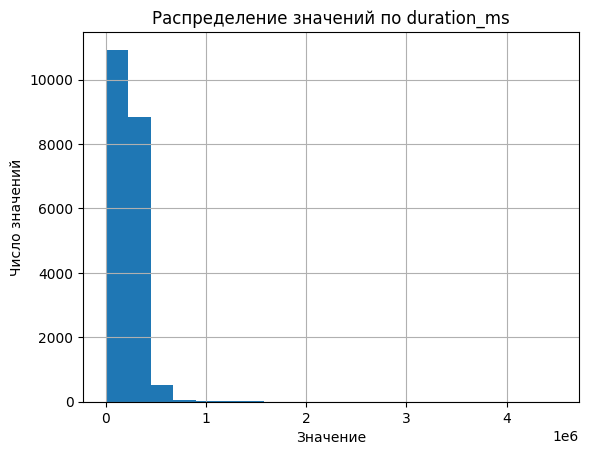

In [29]:
#вывод гистограммы
df_train['duration_ms'].hist(bins=20)
plt.title('Распределение значений по duration_ms')
plt.ylabel('Число значений')
plt.xlabel('Значение')
plt.show()

In [30]:
#подсчёт числа значений меньше 0
print('Абсолютное число:',len(df_train[df_train['duration_ms']<0]))
print('Относительное число:',100*round(len(df_train[df_train['duration_ms']<0])/len(df_train),4),'%')

Абсолютное число: 2009
Относительное число: 9.85 %


In [31]:
#вывод первых строк
df_train[df_train['duration_ms']<0].head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
13,73565.0,Iwanakutemo Tsutawaru Arewa Sukoshi Usoda - All Time Best Version,0.1100,0.470,-1.0,0.6410,0.000000,F#,0.155,-7.454,Major,0.0658,86.387,4-Apr,0.6380,Anime
26,87453.0,"Serenade in B flat, K.361 ""Gran partita"": 3. Adagio",0.9910,0.154,-1.0,0.0384,0.902000,X,0.109,-26.909,Major,0.0405,68.199,4-Apr,0.0393,Classical
35,76827.0,Flodgin,0.0848,0.748,-1.0,0.7120,0.000000,D,0.132,-5.651,Major,0.1430,140.055,4-Apr,0.1800,Rap
50,43888.0,Things My Father Said,0.0540,0.482,-1.0,0.6270,0.000003,D,0.111,-5.779,Major,0.0300,95.903,4-Apr,0.1700,Alternative
55,39574.0,"Fidelio, Op. 72, Act I: Ha! Welch ein Augenblick! (Live)",0.9090,0.374,-1.0,0.2270,0.000069,A#,0.686,-18.719,Major,0.0579,78.236,4-Apr,0.2640,Classical


In [32]:
#изучение уникальных значений по столбцу
df_train[df_train['duration_ms']<0]['duration_ms'].unique()

array([-1.])

Видимо -1 - это "значение-заглушка", когда нету данных о длительности. Однако, длительность не может быть отрицательной, а если гуглить треки по названию - они вполне обычные, имеют определённую не-околонулевую длительность. Есть смысл заполнить медианным значением эти данные.

In [33]:
#заполнение отрицательных значений медианой
df_train.loc[df_train['duration_ms']<0,'duration_ms']=df_train.loc[:,'duration_ms'].median()

In [34]:
#проверка заполнения отрицательных значений

print('Абсолютное число:',len(df_train[df_train['duration_ms']<0]))
print('Относительное число:',100*round(len(df_train[df_train['duration_ms']<0])/len(df_train),4),'%')

Абсолютное число: 0
Относительное число: 0.0 %


## Обработка категориальных признаков

### Признак track_name

In [35]:
%%time
#векторизуем названия песен
#создание списков текстов
corpus=list(df_train['track_name'])

#создадим функцию, которая оставит в тексте только англоязычные буквы
def clear_text(text):
    text_0=re.sub(r'[^a-zA-Z]',' ',text)
    text_1=text_0.split()
    text_2=" ".join(text_1)
    return text_2.lower()

#очистка текстов
for i in tqdm(range(len(corpus))):
    corpus[i]=clear_text(corpus[i])
    
#загрузка инструмента лемматизации для английского языка
nlp=spacy.load('en_core_web_sm',disable=['parser','ner'])

#создадим фнукцию, которая вернёт лемматизированный текст
def lemmatize_text(text):
    doc=nlp(text)
    lemm_text=' '.join([token.lemma_ for token in doc])
    return lemm_text


#лемматизация текстов
for i in tqdm(range(len(corpus))):
    corpus[i]=lemmatize_text(corpus[i])
    
#сохранение английских стоп-слов
stopwords=list(nltk_stopwords.words('english'))
#обозначение инструмента подсчёта tf-idf
count_tf_idf=TfidfVectorizer(stop_words=stopwords)    

100%|██████████| 20394/20394 [00:37<00:00, 544.51it/s]

CPU times: user 38 s, sys: 222 ms, total: 38.2 s
Wall time: 38.1 s


In [36]:
#задаём признаки и целевой признак
features_txt=corpus
features_tfidf=count_tf_idf.fit_transform(features_txt)

In [37]:
from sklearn.decomposition import PCA,TruncatedSVD
truncater=TruncatedSVD(n_components=4)
truncated_train=truncater.fit_transform(features_tfidf)
target_txt=df_train['music_genre']

# Отбор финального набора обучающих признаков

## Подготовка к обучению

In [38]:
df_train_ml=df_train
df_train_ml=df_train_ml.drop(['track_name','obtained_date','instance_id','music_genre'],axis=1)
df_train_ml=pd.concat([df_train_ml,pd.DataFrame(truncated_train,columns=['tf0','tf1','tf2','tf3'])],axis=1)
X=df_train_ml
y=df_train['music_genre']

In [39]:
#разделение выборок
X_train, X_test, y_train, y_test= train_test_split(X,
                                                   y, 
                                                   test_size=.2,random_state=234,
                                                   stratify=y)
X_train.shape, X_test.shape

((16315, 16), (4079, 16))

In [40]:
cat_columns = df_train_ml.select_dtypes(include='object').columns
for col in cat_columns.to_list():
    X[col]=X[col].astype('category')
num_columns = df_train_ml.select_dtypes(include='number').columns

from sklearn.preprocessing import QuantileTransformer
scaler=QuantileTransformer()
X_train_scaled  = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])
X_train.shape, X_test.shape

encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_columns])
X_test_ohe = encoder.transform(X_test[cat_columns])

X_train = np.hstack((X_train_scaled, X_train_ohe))
X_test = np.hstack((X_test_scaled, X_test_ohe))

# Выбор и обучение моделей

### Отбор параметров LR

In [41]:
%%time
model = LogisticRegression(C=1,penalty='l1',solver='saga',random_state=234)
params = {}
grid_line = GridSearchCV(model, params, cv=4,
                    scoring='f1_micro')
grid_line.fit(X_train, y_train)
print('cv:',grid_line.best_score_)
y_pred_lr=grid_line.predict(X_test)
y_pred_lr=f1_score(y_test, y_pred_lr,average='micro')
print('test:',y_pred_lr)
print(grid_line.best_params_)

cv: 0.43132079632265213
test: 0.4224074528070605
{}
CPU times: user 4.41 s, sys: 1.31 s, total: 5.72 s
Wall time: 4.18 s


## Отбор параметров LGBM

In [42]:
%%time

iters=[1]
iters_=0
f1_max=0
for i in iters:
    
    #обучение бустера
    booster = lgb.LGBMClassifier(objective='multiclassova',
                                 learning_rate=0.03,
                                 num_leaves=14,
                                 max_depth=7,
                                 num_iterations=800, 
                                 reg_alpha=0.5,
                                 random_state=234)
    booster.fit(X_train, y_train, eval_set=[(X_test, y_test),],
                verbose=0,
                early_stopping_rounds=6)
    y_pred_lgbm=booster.predict(X_test)
    y_pred_lgbm=f1_score(y_test, y_pred_lgbm,average='micro')
    if y_pred_lgbm>f1_max:
        iters_=i,
        f1_max=y_pred_lgbm

    print('iter_param:',i,'f1_score:',y_pred_lgbm)
print('iter_max:',iters_,'f1_score_max:',f1_max)  

iter_param: 1 f1_score: 0.48786467271390055
iter_max: (1,) f1_score_max: 0.48786467271390055
CPU times: user 17.8 s, sys: 8.42 s, total: 26.2 s
Wall time: 16.4 s


### Отбор параметров CatBoost

In [43]:
%%time

iters=[1]
iters_=0
f1_max=0
for i in iters:
    
    #обучение бустера
    cat_booster = CatBoostClassifier(logging_level='Silent',
                                     loss_function = 'MultiClass',
                                     iterations=600,
                                     depth= 4,
                                     l2_leaf_reg = 75,
                                     border_count= 30,
                                     random_seed=234,
                                     custom_loss='F1',
                                     learning_rate = 0.2,
                                     rsm=0.7,
                                     feature_border_type = 'MinEntropy',
                                     od_type='Iter')
    cat_booster.fit(X_train, y_train)
    y_pred_cat=cat_booster.predict(X_test)
    y_pred_cat=f1_score(y_test, y_pred_cat,average='micro')
    if y_pred_cat>f1_max:
        iters_=i,
        f1_max=y_pred_cat

    print('iter_param:',i,'f1_score:',y_pred_cat)
print('iter_max:',iters_,'f1_score_max:',f1_max)  

iter_param: 1 f1_score: 0.486393723951949
iter_max: (1,) f1_score_max: 0.486393723951949
CPU times: user 17.2 s, sys: 1.03 s, total: 18.2 s
Wall time: 5.23 s


# Финальная модель

In [44]:
df_train_ml=df_train
df_train_ml=df_train_ml.drop(['track_name','obtained_date','instance_id','music_genre'],axis=1)
df_train_ml=pd.concat([df_train_ml,pd.DataFrame(truncated_train,columns=['tf0','tf1','tf2','tf3'])],axis=1)
X=df_train_ml
y=df_train['music_genre']

cat_columns = df_train_ml.select_dtypes(include='object').columns
for col in cat_columns.to_list():
    X[col]=X[col].astype('category')
num_columns = df_train_ml.select_dtypes(include='number').columns

#выделение категориальных и численных признаков
from sklearn.preprocessing import QuantileTransformer
scaler=QuantileTransformer()
X_scaled  = scaler.fit_transform(X[num_columns])
encoder = OneHotEncoder(drop='first', sparse=False)
X_ohe = encoder.fit_transform(X[cat_columns])
X = np.hstack((X_scaled, X_ohe))

In [51]:
%%time
estimators = [('lr', grid_line.best_estimator_), 
              ('lgb', booster),
              ('rf', RandomForestClassifier())]
modelClf = StackingClassifier(estimators=estimators, final_estimator=SVC())
model = modelClf
params = {}
grid_full = GridSearchCV(model, params, cv=2,
                    scoring=make_scorer(f1_score, average='micro'))
grid_full.fit(X,y)
print(grid_full.best_score_)
print(grid_full.best_params_)

0.49995096597038347
{}
CPU times: user 11min 30s, sys: 5min 39s, total: 17min 10s
Wall time: 12min 3s


# Тестовая выборка

In [56]:
corpus_test=list(df_test['track_name'])

#очистка текстов
for i in tqdm(range(len(corpus_test))):
    corpus[i]=clear_text(corpus_test[i])

#лемматизация текстов
for i in tqdm(range(len(corpus_test))):
    corpus_test[i]=lemmatize_text(corpus_test[i])
    
features_tfidf_test=count_tf_idf.fit_transform(corpus_test)
truncated_test=TruncatedSVD(n_components=4)
truncated_test=truncated_test.fit_transform(features_tfidf_test)


100%|██████████| 5099/5099 [00:09<00:00, 522.15it/s]


In [57]:

df_test_ml=df_test.drop(columns=['instance_id','obtained_date','track_name'])
df_test_ml=pd.concat([df_test_ml,pd.DataFrame(truncated_test,columns=['tf0','tf1','tf2','tf3'])],axis=1)
#заполняем пропуски заглушкой
df_test_ml['key']=df_test_ml['key'].fillna('X')
#заполняем пропуски заглушкой
df_test_ml['mode']=df_test_ml['mode'].fillna('Major')
df_test_ml['tempo']=df_test_ml['tempo'].fillna(df_test_ml['tempo'].median())
X_test=df_test_ml
#выделение категориальных и численных признаков
cat_columns = X_test.select_dtypes(include='object').columns
for col in list(cat_columns):
    X_test[col]=X_test[col].astype('category')
num_columns = X_test.select_dtypes(include='float64').columns


X_scaled_test  = scaler.transform(X_test[num_columns])
X_ohe_test = encoder.transform(X_test[cat_columns])
X_test = np.hstack((X_scaled_test, X_ohe_test))

In [58]:
best_model=grid_full.best_estimator_
test_predictions=best_model.predict(X_test)

a=pd.DataFrame(data=df_test['instance_id'])
b=pd.DataFrame(data=test_predictions,columns=['music_genre'])
c=pd.concat([a,b],axis=1)

c.to_csv('predictions.csv',index=False)
pd.read_csv('predictions.csv')

,instance_id,music_genre
0,48564,Rap
1,72394,Alternative
2,88081,Rap
3,78331,Country
4,72636,Alternative
...,...,...
5094,50532,Country
5095,26255,Rap
5096,67924,Rap
5097,79778,Electronic


# Отчёт

## Описание задачи

Музыкальный сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача: правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Существует подготовленный датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Основная задача - разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

## Описание данных

**Описание датасетов:**

* train.csv - информация (~20000) музыкальных треках, которые будут использоваться в качестве обучающих данных.
* test.csv - информация (~5000) музыкальных треках, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'music_genre' для каждого трека из этого датасета.
* sample_submit.csv - файл предсказаний в правильном формате.
* instance_id - идентификатор трека в тестовом наборе.
* music_genre - Целевой признак. Для каждого трека предскажите категориальное значение соответствующее музыкальному жанру трека.

**Описание полей данных:**
* instance_id - уникальный идентификатор трека
* track_name - название трека
* acousticness - акустичность
* danceability - танцевальность
* duration_ms -продолжительность в милисекундах
* energy - энергичность
* instrumentalness - инструментальность
* key - базовый ключ (нота) произведения
* liveness - привлекательность
* loudness - громкость
* mode - указывает на модальность (мажорную или минорную) трека
* speechiness - выразительность
* tempo - темп
* obtained_date - дата загрузки в сервис
* valence - привлекательность произведения для пользователей сервиса
* music_genre - музыкальный жанр

## Отбор признаков

В качестве обучающих признаков использовались все, за исключением:
* instance_id - идентификатор трека, неинформативен
* obtained_date - дата загрузки (4 уникальных значения), неинформативен

Выполненная предобработка:
* обработаны пропуски столбцов key, mode, tempo: категориальные key и mode заполнены значением-заглушкой, tempo - медианой по сгруппированным по музыкальному жанру данным;
* duration_ms - значения меньше нуля заполнены медианой по столбцу;
* обработаны данные категориальных признаков:
    * mode, key - преобразование через OHE;
    * track_name: векторизован при помощи tf-idf и преобразован sparce matrix в более короткий вектор методом truncatedSVD.
    
**Было опробовано, но не вошло в итоговый отчёт в силу ухудшения или малого влияния на метрику:**
* Создание новых числовых признаков на основе умножения, агрегации существующих: улучшение было только для модели линейной регрессии, на бустинги влияение было скорее отрицательное.
* Применение StandardScaler
* Оформление обучения в пайплайн

## Применение моделей

Данные, обработанные через OHE и QuantileTransformer, были применены для обучения моделей Логистической регрессии, RandomForestClassifier, LightGBM, CatBooster. 

При помощи GridSearchCV и перебора гиперпараметров вручную, были отобраны финальные модели: Логичстическая регрессия, LightGBM, RandomForestClassifier. 

Данные модели были включены в ансамбль StackingClassifier (на выходе SVC) и обучены на всей тренировочной выборке.

## Основные выводы

По результатам работы можно утверждать следующее:
* Создание дополнительных числовых признаков оказало влияние только на линейную модель, тогда как на бустинги - не оказала;
* CatBoost выдавал большие значения f1_score при сравнении с LGBM, однако в составе ансамбля LGBM оказалась лучше;
* QuantileTransformer показал лучший результат, чем StandardScaler,
* Использование tf-idf меры для названий дало небольшой прирост метрики, однако нельзя утверждать, что кардинально изменило значение.